## Initializations

In [4]:
from IPython.display import SVG

import numpy as np
from scipy import sparse
import pandas as pd
from time import time

!pip install scikit-network
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from sklearn.decomposition import randomized_svd

     |████████████████████████████████| 7.5MB 7.4MB/s 


## PageRank implementation
From scikit-learn

In [6]:
def centrality_scores(X, alpha=0.85, max_iter=100, tol=1e-10):

    n = X.shape[0]
    X = X.copy()
    incoming_counts = np.asarray(X.sum(axis=1)).ravel()

    print("Normalizing the graph")
    for i in incoming_counts.nonzero()[0]:
        X.data[X.indptr[i]:X.indptr[i + 1]] *= 1.0 / incoming_counts[i]
    dangle = np.asarray(np.where(np.isclose(X.sum(axis=1), 0),
                                 1.0 / n, 0)).ravel()

    scores = np.full(n, 1. / n, dtype=np.float32)  # initial guess
    for i in range(max_iter):
        
        #print("power iteration #%d" % i)
        prev_scores = scores
        scores = (alpha * (scores * X + np.dot(dangle, prev_scores))
                  + (1 - alpha) * prev_scores.sum() / n)

        # check convergence: normalized l_inf norm
        scores_max = np.abs(scores).max()
        if scores_max == 0.0:
            scores_max = 1.0
        err = np.abs(scores - prev_scores).max() / scores_max
        
        #print("error: %0.6f" % err)
        if err < n * tol:
            return scores

    return scores


## Graph creation


In [8]:
dummyEntities = np.random.rand(5,5)
EntitiesRelatedness = 1 - (dummyEntities + dummyEntities.T)/2 # symetric matrix

Entities_graph = sparse.csr_matrix(1.0*(EntitiesRelatedness > 0.2))

adjacency = sparse.csr_matrix(Entities_graph)
entity_names= ("one", "two", "three", "four", "five")


In [23]:
Entities_graph.todense()

matrix([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.]])

In [24]:
adjacency.todense()

matrix([[1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.]])

## PageRank computation

In [13]:
t0 = time()
Entities_Rank = centrality_scores(Entities_graph)
print("done in %0.3fs" % (time() - t0))


Normalizing the graph
done in 0.011s


## PageRank results visualization

In [19]:
import pprint
pprint.pprint(np.sum(Entities_Rank))
pprint.pprint(Entities_Rank)

1.000000012665987
array([0.1843318 , 0.22350231, 0.1843318 , 0.22350231, 0.1843318 ])


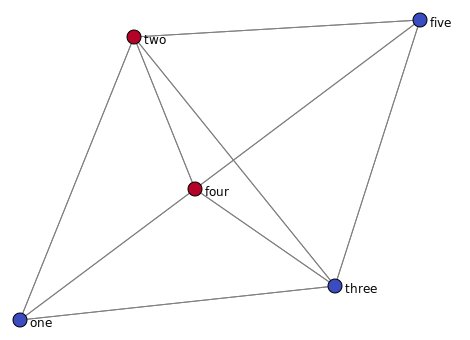

In [32]:

image = svg_graph(adjacency, scores=np.log(Entities_Rank), names = entity_names)
SVG(image)


## Now with the scikit-network implementation

1.0
array([0.18433173, 0.22350241, 0.18433173, 0.22350241, 0.18433173])


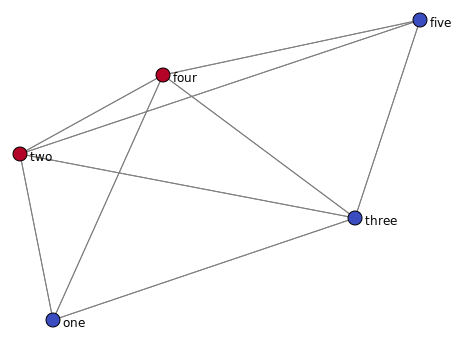

In [26]:
from sknetwork.ranking import PageRank, BiPageRank

pagerank = PageRank()
scores = pagerank.fit_transform(adjacency)

pprint.pprint(np.sum(scores))
pprint.pprint(scores)

image = svg_graph(adjacency, scores=np.log(scores), names=entity_names, display_node_weight=False)

SVG(image)



## Graph of named entities across multiple documents
Consider the following two documents and the four named entities ("UNL", "Lisbon", "Portugal", "Europe"):

- Document 1: "Lisbon is in Europe"
- Document 2: "UNL is in Lisbon"


In [34]:
A = np.array(([0,1,0,1],
              [1,1,0,0]))
A.shape

(2, 4)

In [35]:
Graph = A.T.dot(A)*(1-np.eye(4))
print(Graph)

[[0. 1. 0. 0.]
 [1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]]
